<a href="https://colab.research.google.com/github/rswijesena/AI/blob/main/Basic_Image_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [3]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor 128 x 784
  data = tensor.detach().cpu().view(-1, ch, *size)
  grid = make_grid(data[:num], nrow = 4).permute(1,2,0)
  plt.imshow(grid)
  plt.show()


In [4]:
# setup if the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

#number of steps = 60000 / 128 = 468.75

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5096631.62it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133561.60it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1272026.80it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10347924.37it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
# decalare our model

#Generator

def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )
class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim = 128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), #64 128
        genBlock(h_dim, h_dim*2), #128 , 256
        genBlock(h_dim*2, h_dim*4), # 256 , 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28*28)
        nn.Sigmoid()
    )
  def forward(self, noice):
    return self.gen(noice)

def gen_noise(number, z_dim):
  return torch.randn(number,z_dim).to(device)

## Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), #784 1024
        discBlock(h_dim*4, h_dim*2), #1024 512
        discBlock(h_dim*2, h_dim), #512 256
        nn.Linear(h_dim, 1) #256 1
    )

  def forward(self, image):
      return self.disc(image)




In [12]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [7]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([8, 8, 3, 3, 4, 8, 8, 0, 9, 8])


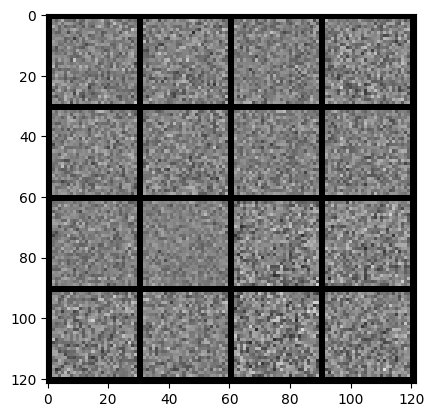

In [8]:
x,y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)


In [16]:
#calculation the loss
# generator loss

def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  pred = disc(fake)
  targets = torch.ones_like(pred)
  gen_loss = loss_func(pred, targets)

  return gen_loss

def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
  noise = gen_noise(number, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())
  disc_fake_targets= torch.zeros_like(disc_fake)
  disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets= torch.ones_like(disc_real)
  disc_real_loss = loss_func(disc_real, disc_real_targets)

  disc_loss = (disc_fake_loss + disc_real_loss) /2

  return disc_loss





  0%|          | 0/469 [00:00<?, ?it/s]

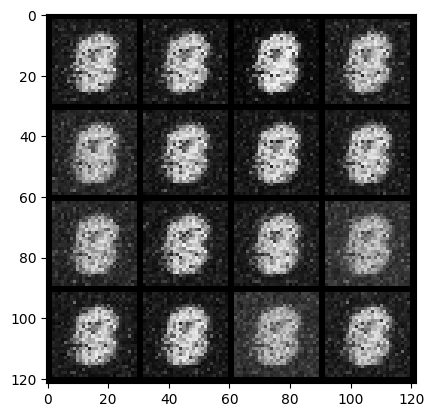

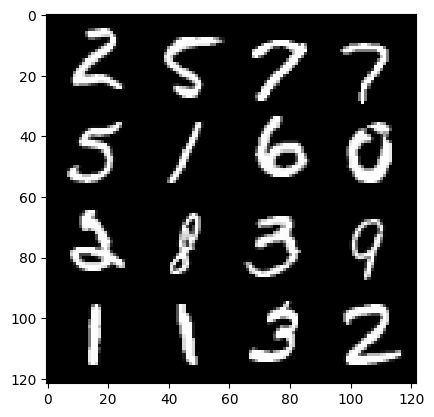

0 : step 300 / Gen Loss 2.153526673913002 / Disc Loss 0.3254420887182157


  0%|          | 0/469 [00:00<?, ?it/s]

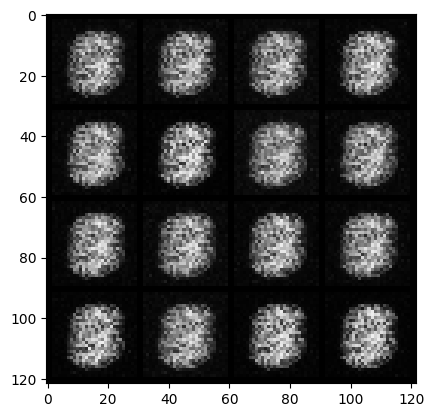

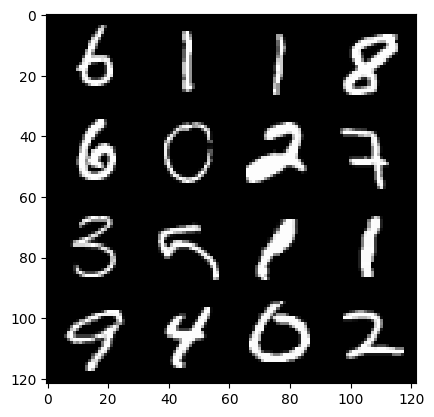

1 : step 600 / Gen Loss 3.7314175629615756 / Disc Loss 0.10218252552052345


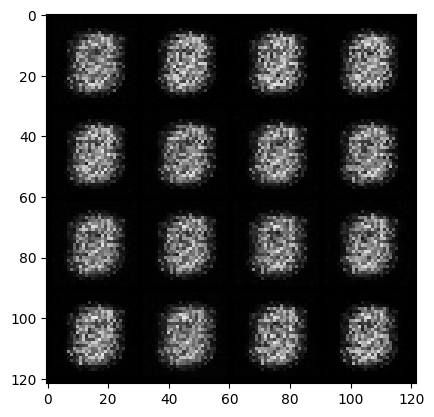

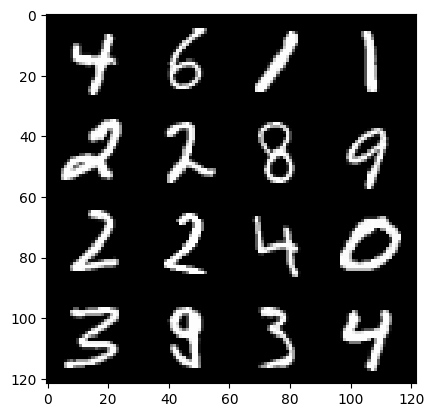

1 : step 900 / Gen Loss 3.797479931513471 / Disc Loss 0.04114447067802149


  0%|          | 0/469 [00:00<?, ?it/s]

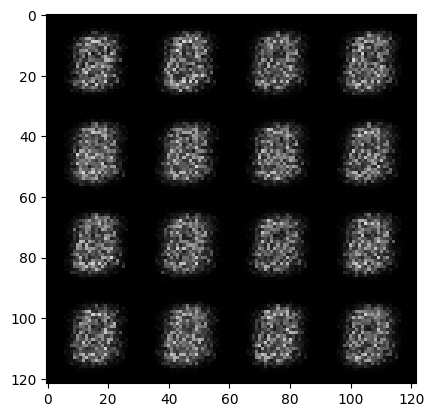

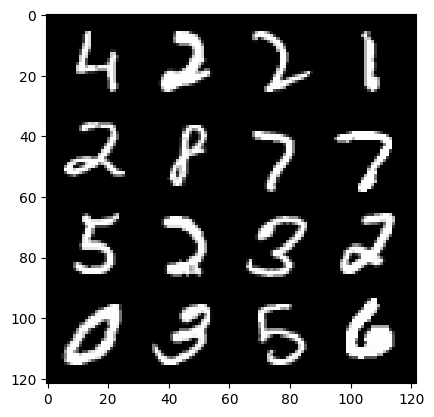

2 : step 1200 / Gen Loss 3.810284608205159 / Disc Loss 0.028870125027994326


  0%|          | 0/469 [00:00<?, ?it/s]

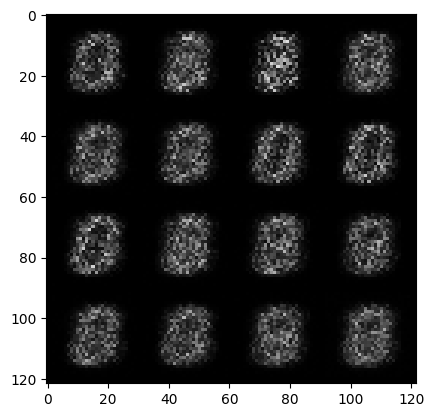

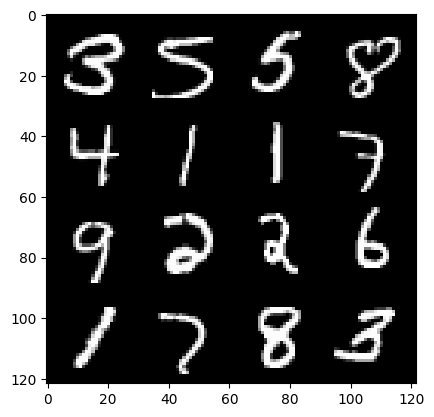

3 : step 1500 / Gen Loss 3.5764458934466044 / Disc Loss 0.0368686292072137


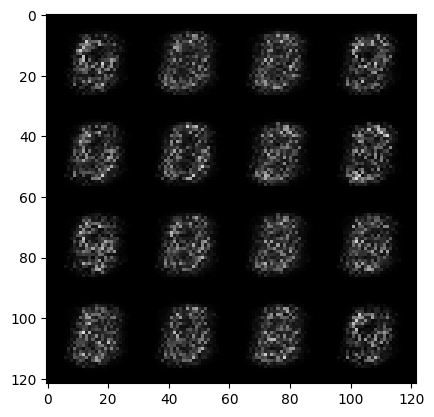

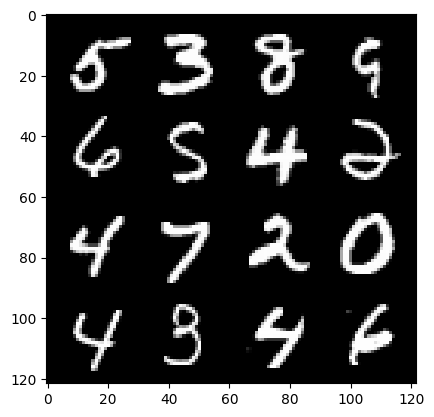

3 : step 1800 / Gen Loss 3.382476430733999 / Disc Loss 0.05137432125707469


  0%|          | 0/469 [00:00<?, ?it/s]

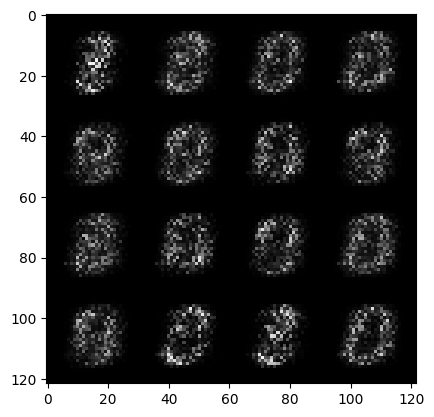

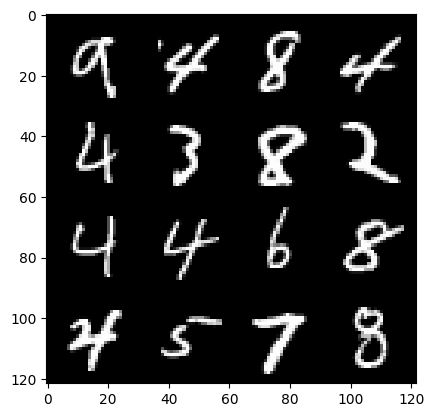

4 : step 2100 / Gen Loss 3.612261951764422 / Disc Loss 0.044934142449249835


  0%|          | 0/469 [00:00<?, ?it/s]

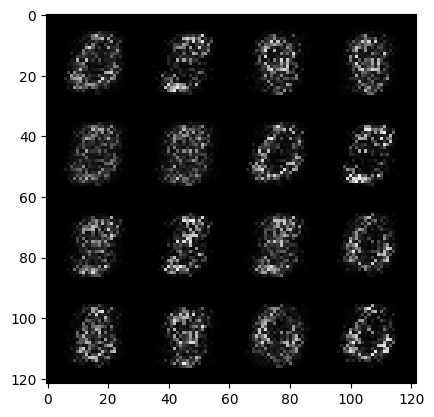

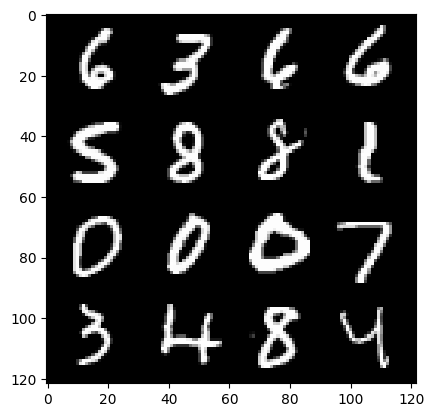

5 : step 2400 / Gen Loss 4.093967220783233 / Disc Loss 0.03664123877262078


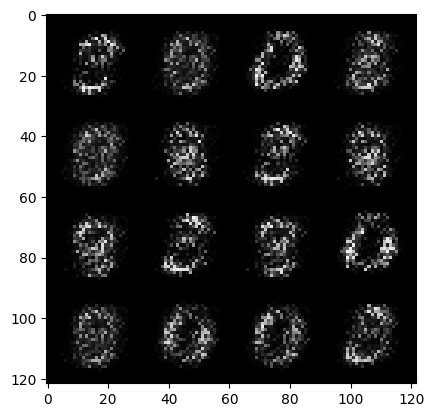

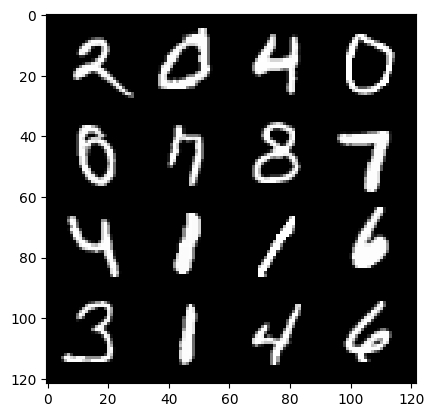

5 : step 2700 / Gen Loss 4.282541125615434 / Disc Loss 0.03055521264051398


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
### 60000 / 128 468.75 = 469 steps in each epoch

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### Discriminator
    disc_opt.zero_grad()

    cur_bs = len(real) # real : 128 x 1 x 28 x28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real, z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ##Generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ## Visualizaiton
    mean_disc_loss += disc_loss.item()/info_step
    mean_gen_loss += gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step >0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch} : step {cur_step} / Gen Loss {mean_gen_loss} / Disc Loss {mean_disc_loss}")
      mean_gen_loss = 0
      mean_disc_loss = 0
    cur_step += 1
